In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import laplace
from skimage import feature

from load import *

plt.rcParams['figure.figsize'] = (16, 16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# generate filenames
files = []
for i in range(1,4):
    for j in range(1,5):
        prefix = 'data/AMG%d_exp%d'%(i,j)
        files.append( (prefix+'.tif', prefix+'.zip') )

In [15]:
# load data
data = []
for i,(s,r) in enumerate(files):
    if i==8: # lolwtf
        data.append((load_stack(s), load_rois(r, 512, 512, xdisp=9, ydisp=-1)))
    else:
        data.append((load_stack(s), load_rois(r, 512, 512)))

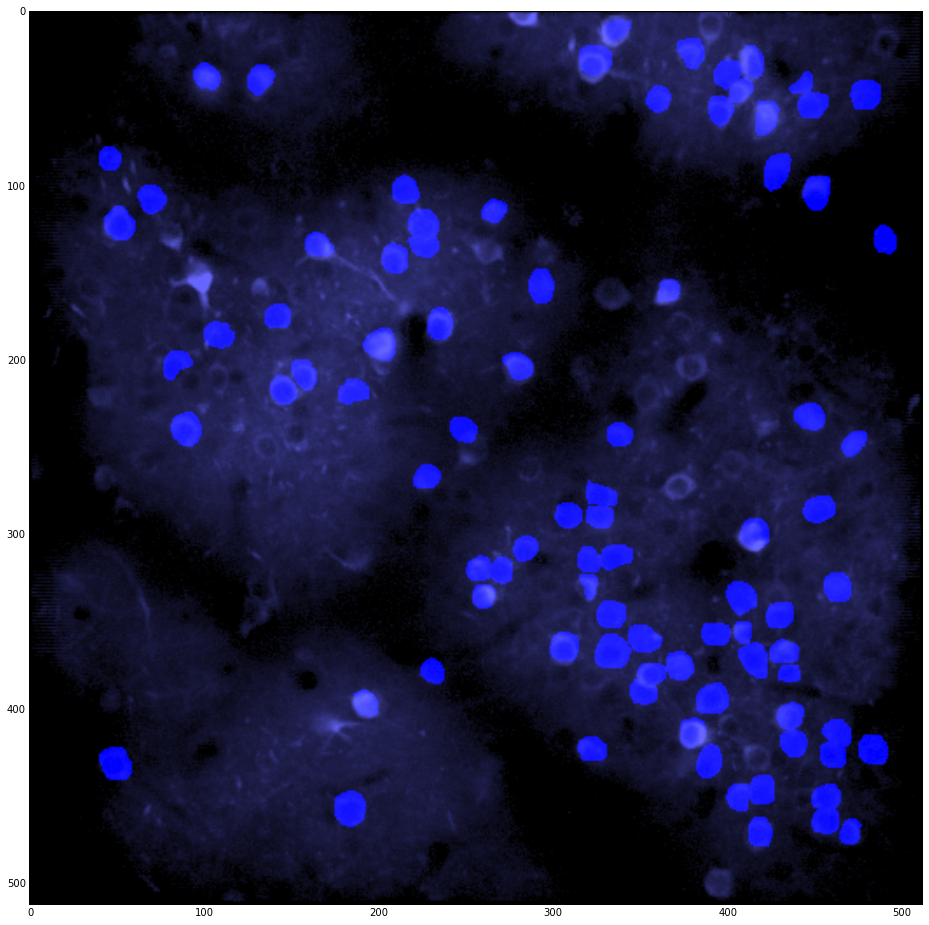

In [16]:
# visualize one set
stk,rois = data[8]

M = stk.max(axis=0)
M = np.clip( (M-900)/500, 0, 1 )
M**=0.5

R = rois.max(axis=0)

K = np.zeros((512,512,3))
K[:,:,0] = K[:,:,1] = K[:,:,2] = M*0.4
K[:,:,2] = np.maximum(M,R)

plt.imshow(K)

In [17]:
# load all 2*r by 2*r tiles centered on neuron centroids
def NormalizeTile(tile):
    return (tile - tile.mean()) / tile.std()

w,h = [], []
tiles = []
Ztiles = []
r = 15

for stk, rois in data:
    M = stk.max(axis=0)
    for roi in rois:
        x,y = np.where(roi!=0)
        x,y = int(x.mean()), int(y.mean()) # compute centroid of roi
        if x-r>=0 and y-r>=0 and x+r<512 and y+r<512:
            tiles.append(M[x-r:x+r, y-r:y+r]) # grab tile
            Ztiles.append(NormalizeTile(M[x-r:x+r, y-r:y+r])) # grab z-scored tile
            
tiles = np.array(tiles)
Ztiles = np.array(Ztiles)

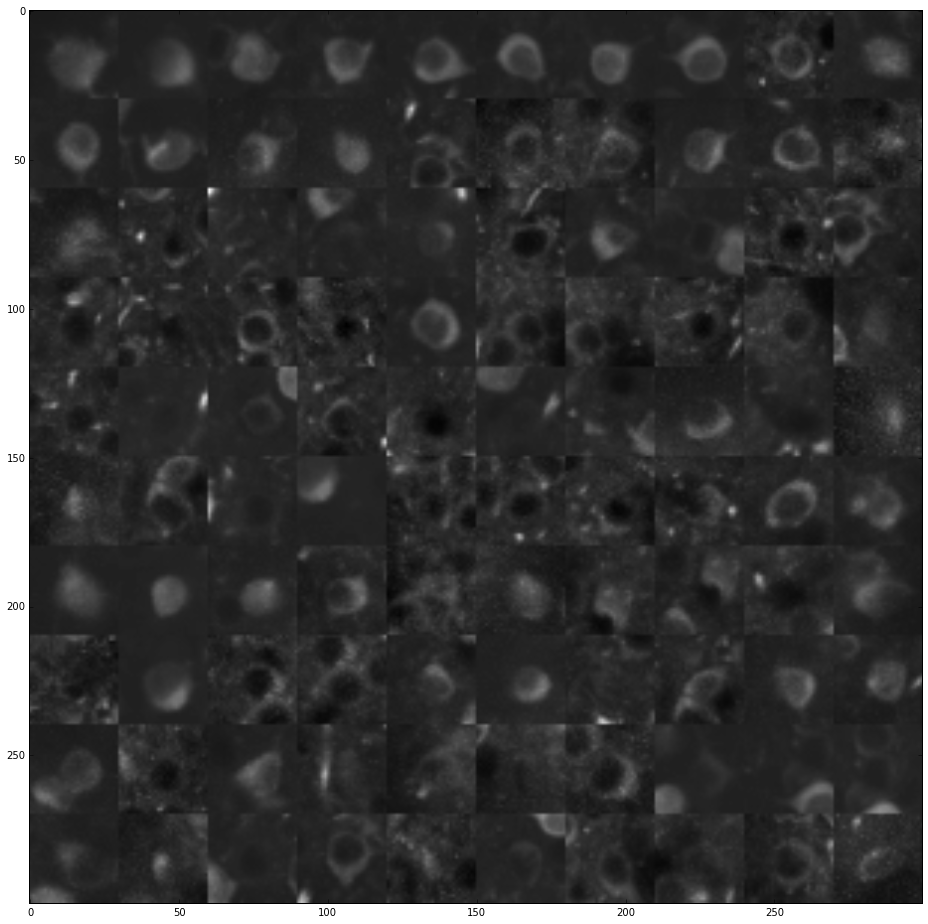

In [18]:
# render tiled image
Q = np.zeros((2*r*10, 2*r*10))
for i in range(10):
    for j in range(10):
        Q[2*r*i:2*r*(i+1),2*r*j:2*r*(j+1)] = Ztiles[10*i + j]

plt.imshow(Q,cmap='gray')

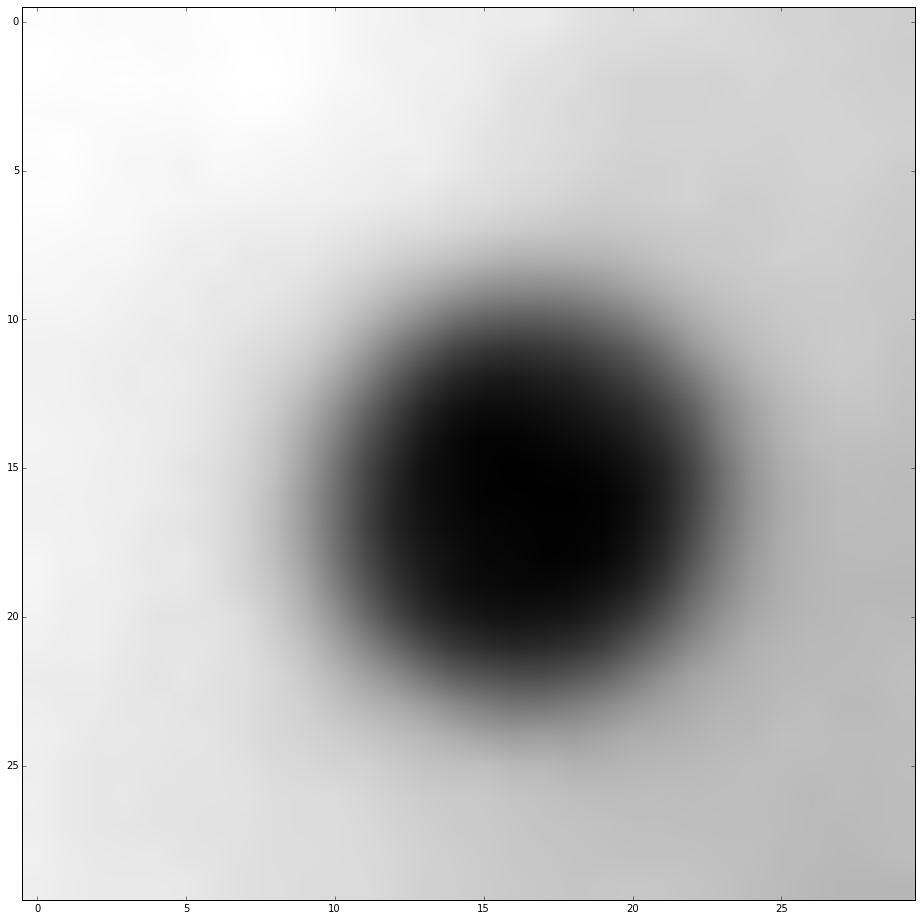

In [27]:
# flatten 30x30 images to 900x1 vectors
Zvecs = Ztiles.copy()
Zvecs = Zvecs.reshape((Zvecs.shape[0], Zvecs.shape[1]*Zvecs.shape[2]))

# run pca
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(Zvecs)

# render 1st principal component
plt.imshow( pca.components_[0].reshape(30,30), cmap='gray')

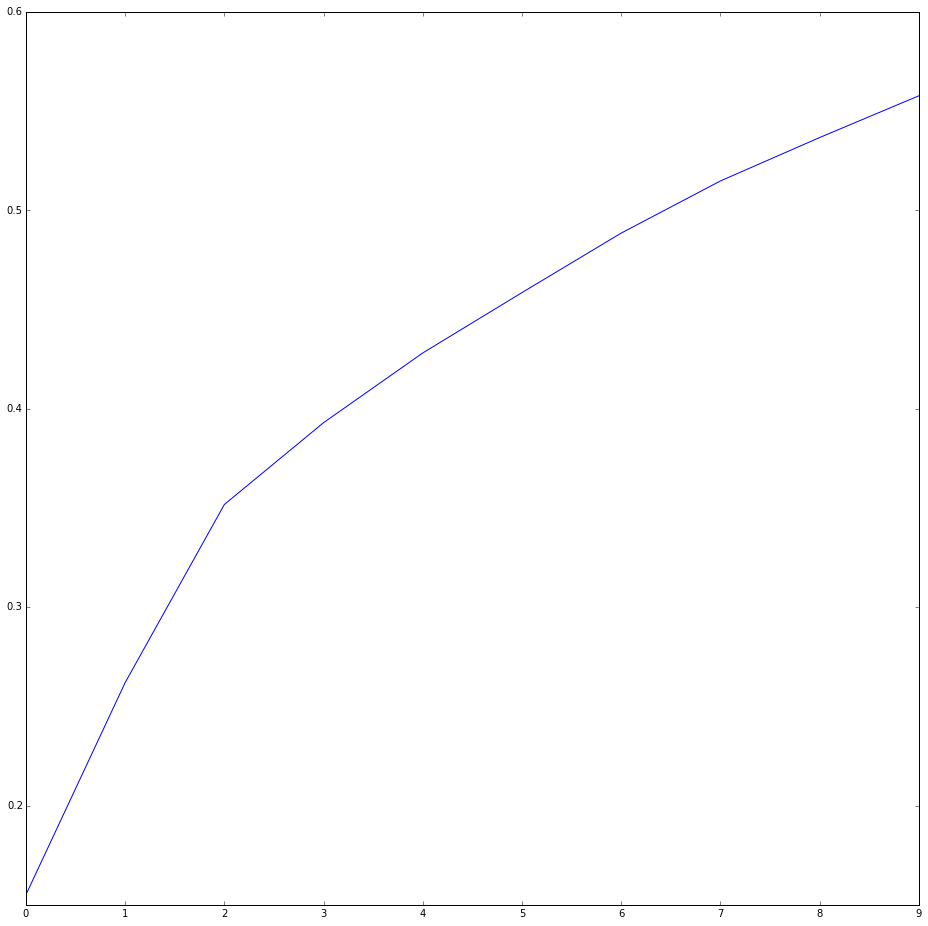

In [28]:
# explained variance curve
plt.plot(np.cumsum(pca.explained_variance_ratio_))

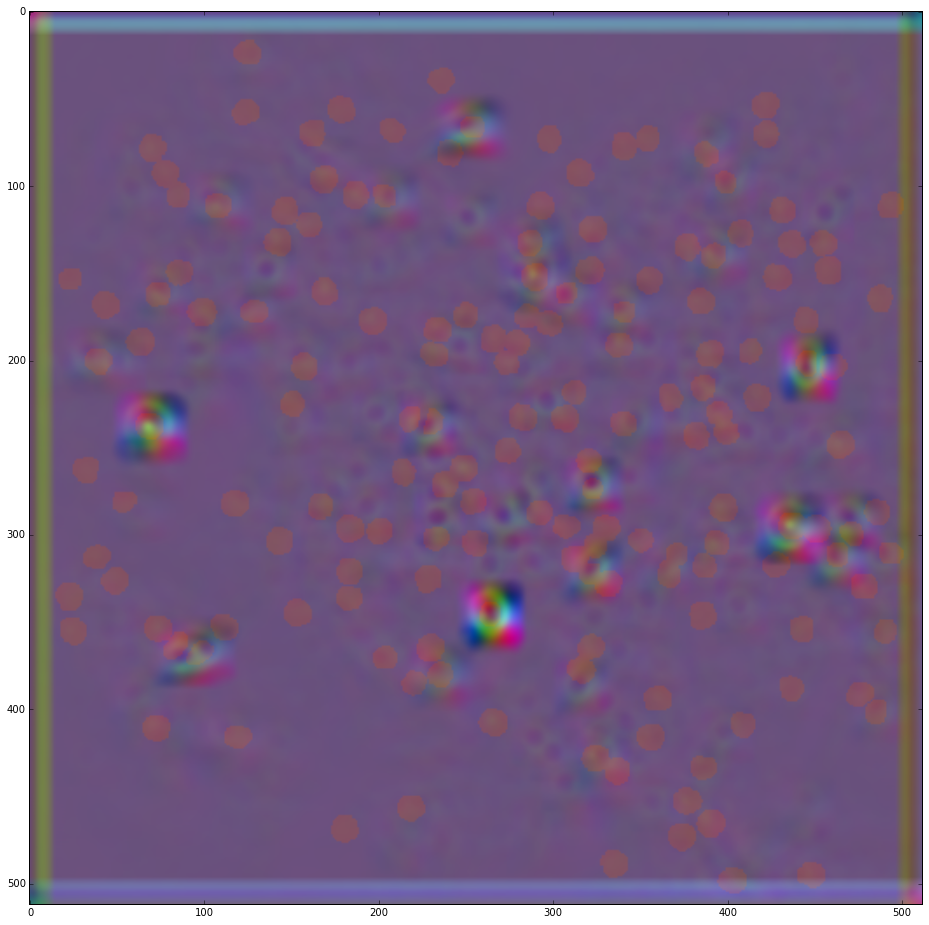

In [29]:
# compute 2d cross-correlation with principal components as filters
from scipy.signal import correlate2d

filt = [pc.reshape(30,30) for pc in pca.components_]
Ci = [correlate2d(M, f, mode='same') for f in filt]

Q = np.zeros((512,512,3))

def sc(K):
    return (K-K.min())/(K.max()-K.min())

Q[:,:,0] = sc(Ci[3])
Q[:,:,1] = sc(Ci[4])
Q[:,:,2] = sc(Ci[5])
plt.imshow(Q)

plt.imshow(rois.any(axis=0), alpha=0.2)

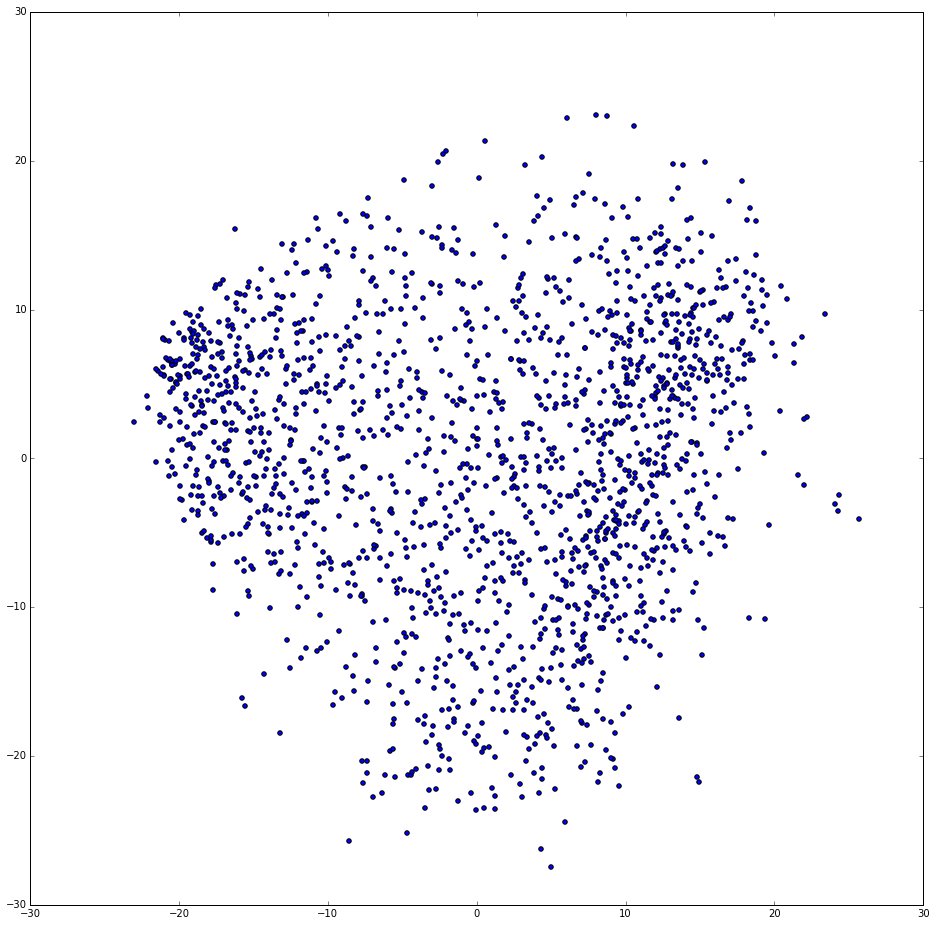

In [30]:
# plot points on first two principal components
Zt = pca.transform(Zvecs)
plt.scatter(Zt[:,0], Zt[:,1])